## Exploratory code to detect bat observations in wind turbine videos

The notebook provides code for video preprocessing using CV to detect movement between video frames and 
<br>
an ipywidgets interactor to allow one to select random frames and extract out labeled images of bats.

#### Colin Talbert, USGS Fall 2018
talbertc@usgs.gov

In [1]:
%%HTML
<div align="middle">
<video width="80%" controls>
      <source src="demo_bats.mp4" type="video/mp4">
</video></div>

In [1]:
from ipywidgets import interact, interactive
import random

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

import ipywidgets as widgets

import numpy as np
import cv2 as cv

import scipy

from scipy import ndimage

from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb

from skimage.feature import blob_dog, blob_log, blob_doh
from matplotlib.patches import Rectangle
import copy 

import warnings; warnings.simplefilter('ignore')

In [2]:
fname = r"K:\USERS\TSH\Personnel\CRYAN\Colin\NREL merged.avi"

batvid = cv.VideoCapture(fname)

nframes = batvid.get(cv.CAP_PROP_FRAME_COUNT)

out_dname = r"C:\temp\test"

In [3]:

def get_img(frame, splitheader=False):
    # Returns an array of the rgb color for a given frame.
    # If splitheader is True remove the black header portion of the frame.
    batvid.set(cv.CAP_PROP_POS_FRAMES, frame)
    data = batvid.read()[1]
    data = cv.cvtColor(data, cv.COLOR_BGR2RGB)
    if splitheader:
        header = data[:20, :, :]
        data = data[20:, :, :]
        return (data, header)
    else:
        return data

In [4]:
fgbg = cv.bgsegm.createBackgroundSubtractorMOG(history=3, )

images = []
diff_images = []
flat_diff_images = []

num_frames = 2000

progressbar = widgets.IntProgress(
    value=0,
    min=0,
    max=num_frames,
    step=1,
    description='Loading:',
    bar_style='', # 'success', 'info', 'warning', 'danger' or ''
    orientation='horizontal'
)

display(progressbar)

# This is where we read the data into a 3d cube of images.
# 
for i in range(num_frames):
    data = get_img(i, splitheader=True)[0]
    images.append(data)
    
    diffdata = fgbg.apply(data)
    diffdata = diffdata[..., None]
    diffdata = np.tile(diffdata, 3)
    diffdata[diffdata==255] = data[diffdata==255]
#     flat_diff_images.append(resize(data, (128, 128)).flatten())
    diff_images.append(diffdata)
    progressbar.value = i


    
diff_images = np.asarray(diff_images)
h, w = diff_images.shape[1:3]

IntProgress(value=0, description='Loading:', max=2000)

In [5]:
data = get_img(0, splitheader=True)[0]

x_breaks = np.linspace(0, data.shape[1], 4)
y_breaks = np.linspace(0, data.shape[0], 4)

def find_quadrant(x, y):
    # Returns the quadrant's start location and width, height of
    # (3x3) of a given x, y locatation.  
    # This is used to translate click location to the associated pixels for labeling. 
    x_index = np.argmax(np.where(x_breaks <= x))
    y_index = np.argmax(np.where(y_breaks <= y))
    
    x_range = int(x_breaks[x_index]), int(x_breaks[x_index+1])
    y_range = int(y_breaks[y_index]), int(y_breaks[y_index+1])
    return ((x_range[0], y_range[0]), 
             x_range[1]-x_range[0],
            y_range[1]-y_range[0])

find_quadrant(410,0)

((213, 0), 213, 153)

###  The following cell allows you to interactively view the loaded data change the length of the time you want to capture movement from and label quadrants that contain bats.
The labeled images will be written out to individual files for subsequent machine learning algorithms. 
### The idea is that you would click the random frame button and then identify quadrants that contain bats by clicking in them.  These selections will be save for latter writting out to disk.

In [7]:
%matplotlib notebook
bats = {}

from ipywidgets import interact, interactive

def plotone(f=10, numframes=10):
    
    f_slider.min = numframes
    
    temporal_data = diff_images[f-numframes:f, :, :, :].max(axis=0)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5),
                       subplot_kw=dict(xticks=[], yticks=[]))
    
    def onclick(event):
        bat_obs = copy.deepcopy(bats.get(f, []))
        
        
        
        pad = 50
        coords = find_quadrant(event.xdata, event.ydata)
        if coords in bat_obs:
            del bat_obs[bat_obs.index(coords)]
        else:
            bat_obs.append(coords)
        
    
    
        
        [p.remove() for p in reversed(ax[0].patches)]
        [p.remove() for p in reversed(ax[1].patches)]
        
        bats[f] = bat_obs
        
        for c in bat_obs:
            rect = Rectangle(*c,  facecolor='red', alpha=0.6,
                         edgecolor='blue')
            rect2 = Rectangle(*c,  facecolor='red', alpha=0.6,
                         edgecolor='blue')
            ax[0].add_patch(rect)
            
            ax[1].add_patch(rect2)
        
        
    cid = fig.canvas.mpl_connect('button_press_event', onclick)
    
    ax[0].imshow(images[f]) # ax[0] means the first of two subplots
    ax[0].set_title('input image')
    ax[0].set_xticks(np.linspace(0, data.shape[1], 4))
    ax[0].set_yticks(np.linspace(0, data.shape[0], 4))
    ax[0].grid()

    ax[1].imshow(temporal_data) # ax[1] means the second of two subplots
    ax[1].set_title('visualization of movement');
    ax[1].set_xticks(np.linspace(0, data.shape[1], 4))
    ax[1].set_yticks(np.linspace(0, data.shape[0], 4))
    ax[1].grid()
    
    plt.tight_layout()
    
    
def next_random(b):
    frame = random.choice(range(0, diff_images.shape[0]-1))
    f_slider.value = frame

    
    
b = widgets.Button(
    description='Next Random Frame',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Next Random Frame',
    icon='check'
)
b.on_click(next_random)
display(b)

    
#     plt.imshow(diff_images[frame, :,:,:])

f_slider = widgets.IntSlider(min=10, max=diff_images.shape[0])

interact(plotone, f=f_slider, numframes=(0,50))

Button(description='Next Random Frame', icon='check', style=ButtonStyle(), tooltip='Next Random Frame')

interactive(children=(IntSlider(value=10, description='f', max=2000, min=10), IntSlider(value=10, description=…

<function __main__.plotone>

### Now that we've identified some frames that contain bats save them out to a set of labeled images

In [8]:
import pickle

pickle.dump(bats, open(r"c:\temp\bats.p", "wb"))


In [9]:
import os
from PIL import Image

root_dname = r"C:\temp\TF"


def save_frame(frame, bat_coords):

    cell = 1
    
    temporal_data = diff_images[frame-27:frame, :, :, :].max(axis=0)
    
    for i in range(1, len(x_breaks)):
        for j in range(1, len(y_breaks)):
    #         print(f"{int(x_breaks[i-1])}:{int(x_breaks[i])}", f"{int(y_breaks[j-1])}:{int(y_breaks[j])}")
            data = temporal_data[int(y_breaks[j-1]):int(y_breaks[j]), int(x_breaks[i-1]):int(x_breaks[i]), :]
        
            for bat in bat_coords:
                if bat[0] == (int(x_breaks[i-1]), int(y_breaks[j-1])):
                    fname = os.path.join(root_dname, 'bat', f"{frame}_{cell}.png")
                    break
                else:
                    fname = os.path.join(root_dname, 'notbat', f"{frame}_{cell}.png")

            im = Image.fromarray(data)
            im.save(fname)
            cell += 1

for frame, bat_coords in bats.items():
    print(frame)
    if bat_coords:
        save_frame(frame, bat_coords)   

491
1841
1555
752
594
1338
57
1057
1050
391
612
718
934


In [14]:
f = 491
numframes = 20
bats[491]

[((213, 0), 213, 153)]

<IPython.core.display.Javascript object>


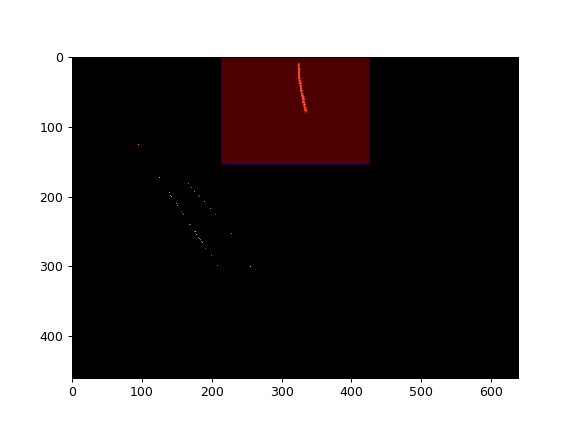

In [19]:
%matplotlib notebook
frame = random.choice(list(bats.keys()))
bat_coords = bats[frame]

temporal_data = diff_images[frame-numframes:frame, :, :, :].max(axis=0)
plt.imshow(temporal_data)

for bat in bat_coords:
    rect = Rectangle(*bat,  facecolor='red', alpha=0.3,
                         edgecolor='blue')
    plt.gca().add_patch(rect)

plt.show()

### Export a video of this output

<IPython.core.display.Javascript object>


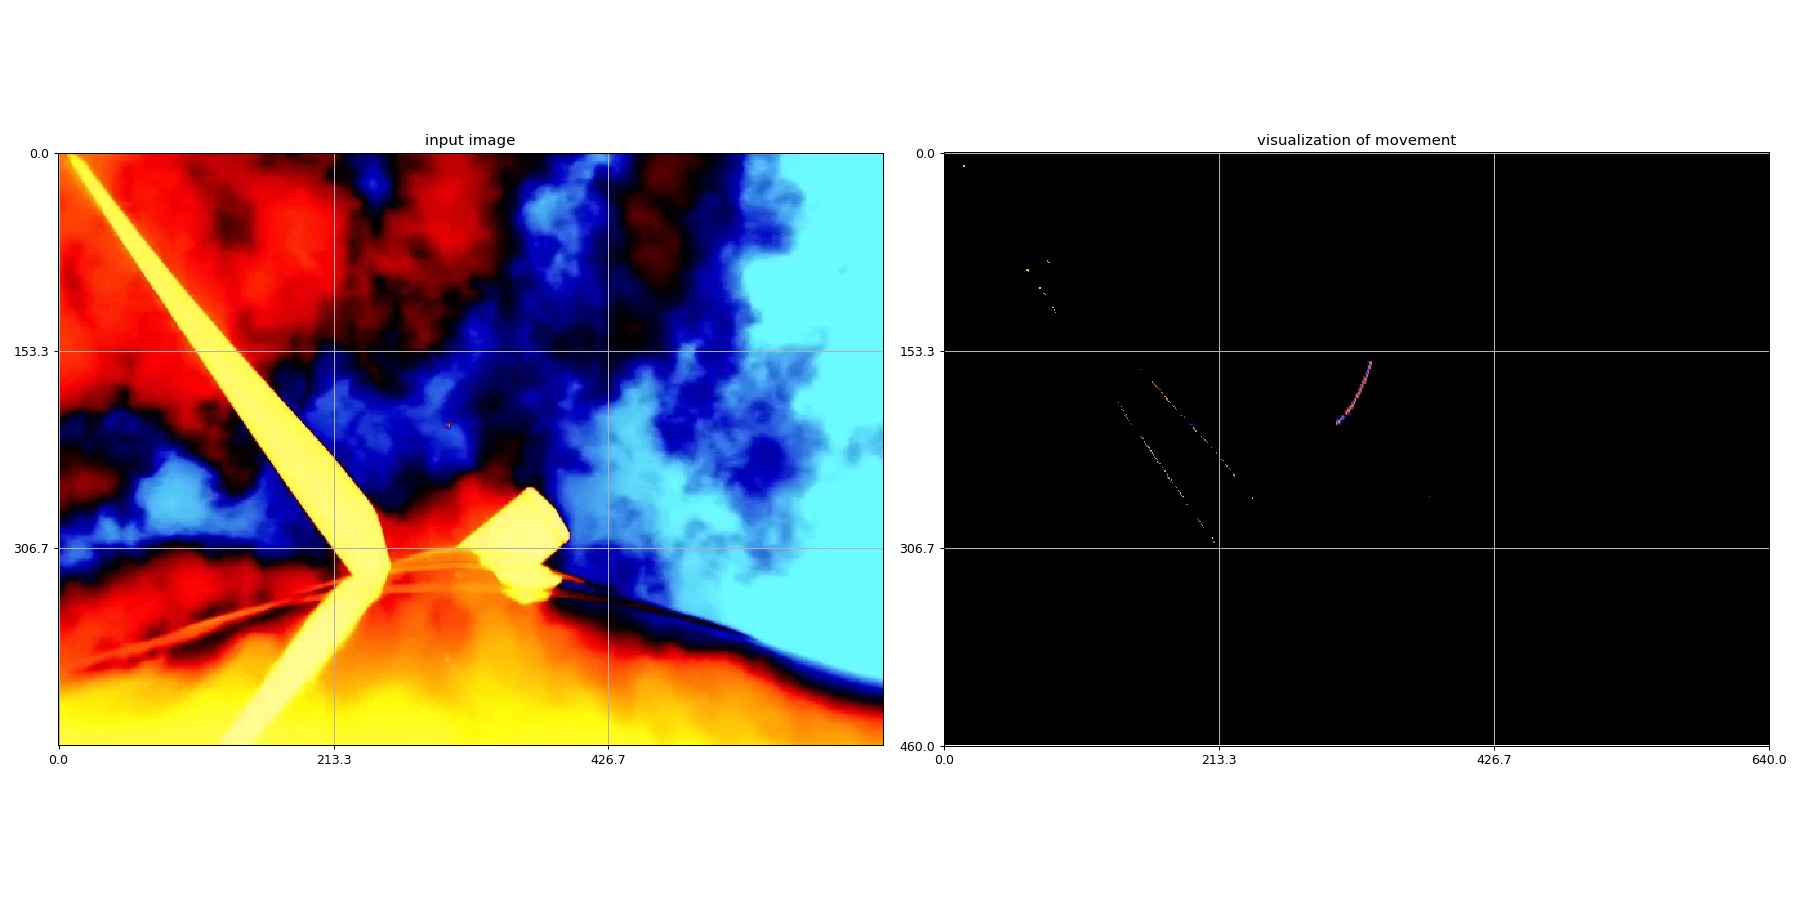

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.animation as animation


class SubplotAnimation(animation.TimedAnimation):
    def __init__(self):
        fig, ax = plt.subplots(1, 2, figsize=(20, 10),
                               subplot_kw=dict(xticks=[], yticks=[]))

         # ax[0] means the first of two subplots
        ax[0].set_title('input image')
        ax[0].set_xticks(np.linspace(0, data.shape[1], 4))
        ax[0].set_yticks(np.linspace(0, data.shape[0], 4))
        ax[0].grid()
        
        self.im0 = ax[0].imshow(images[f], animated=True)
        

        self.im1 = ax[1].imshow(temporal_data, animated=True) # ax[1] means the second of two subplots
        ax[1].set_title('visualization of movement');
        ax[1].set_xticks(np.linspace(0, data.shape[1], 4))
        ax[1].set_yticks(np.linspace(0, data.shape[0], 4))
        ax[1].grid()

        plt.tight_layout()

        animation.TimedAnimation.__init__(self, fig, interval=50, blit=True)

    def _draw_frame(self, framedata):
        f = framedata
        temporal_data = diff_images[f-numframes:f, :, :, :].max(axis=0)
        self.im0.set_array(images[f])
        self.im1.set_array(temporal_data) # ax[1] means the second of two subplots

    def new_frame_seq(self):
        return iter(range(20, 500))

ani = SubplotAnimation()
ani.save('demo_bats.mp4')
plt.show()